<a href="https://colab.research.google.com/github/ziatdinovmax/GP/blob/master/notebooks/GP_BEPFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gaussian Process Regression Applied to Hyperspectral Data from BE-PFM Experiments

Prepared by Maxim Ziatdinov (October 2019)

Email: ziatdinovmax@gmail.com

This notebook demonstates application of Gaussian process regression to reconstruction of (artificially corrupted) BE-PFM hyperspecral data and to a sample exploration based on uncertainty.

---
**Important:** For the best results, please run this notebook with the latest generation GPUs, such as Nvidia's Tesla P100 and Tesla V100. You can get those GPUs in a cloud by [connecting](https://blog.kovalevskyi.com/gce-deeplearning-images-as-a-backend-for-google-colaboratory-bc4903d24947) this Colab notebook to a [Deep Learning VM](https://cloud.google.com/deep-learning-vm/) on Google Cloud Platform. It is also possible to run this notebook in Google Colab hosted runtime with Tesla K80 GPU by decreasing the number of inducing points (< 250), but the results will be sub-optimal.


---



Check your cloud GPU:

In [0]:
!nvidia-smi

Thu Oct 10 04:17:01 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.104      Driver Version: 410.104      CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
#@title Import/install modules { form-width: "20%" }
import os
import copy
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
try:
    import pyro
except:
    ModuleNotFoundError
    !echo 'Installing Pyro library...'
    !pip install pyro-ppl > /dev/null
    import pyro
if 'GP' not in os.path.split(os.getcwd()):
    try:
        os.chdir('GP')
    except FileNotFoundError:
        !echo -e "Cloning package for GP analysis of hyperspectral data..."
        !git clone https://github.com/ziatdinovmax/GP.git
        os.chdir('GP')
import torch
import gpr
import gprutils
pyro.set_rng_seed(0)
torch.set_default_tensor_type(torch.DoubleTensor)

In [0]:
#@title Helper functions { form-width: "20%" }

def print_attrs(name, obj):
    print(name)
    for k, v in obj.attrs.items():
        print("  {}: {}".format(k, v))

def inspect_dataset(hf, **kwargs):
    hf.visititems(print_attrs)
    return

def get_raw_data(hf, measurement='Measurement_000', channel='Channel_000'):
    raw_data = hf[measurement+'/'+channel+'/Raw_Data'][:]
    return raw_data

def get_dims(hf, measurement='Measurement_000'):
    cols = hf[measurement].attrs['grid_num_cols']
    rows = hf[measurement].attrs['grid_num_rows']
    bins = hf[measurement].attrs['num_bins']
    return cols, rows, bins 

def get_spectr_info(hf, measurement='Measurement_000', channel='Channel_000'):
    spec_values = hf[measurement+'/'+channel+'/Spectroscopic_Values'][:]
    spec_units = hf[measurement+'/'+channel+'/Spectroscopic_Indices'].attrs['units']
    spec_label = hf[measurement+'/'+channel+'/Spectroscopic_Indices'].attrs['labels']
    return spec_values, spec_units[0].decode('utf-8'), spec_label[0].decode('utf-8')

### Review dataset(s)

Select a file to work with and print the hdf5 file data tree:

In [3]:
datadir = 'test_data'
filename = 'BEPFM image_0001 - 128 x 128.h5'

hf = h5py.File(os.path.join(datadir, filename), 'r')
inspect_dataset(hf)

Measurement_000
  AFM_InvOLS: 1e-07
  AFM_XLVDT_sensor: 4.2214e-06
  AFM_XPiezo_sensitivity: -1.7437e-07
  AFM_YLVDT_sensor: 4.3626e-06
  AFM_YPiezo_sensitivity: 1.8489e-07
  AFM_ZLVDT_sensor: 4.790395e-06
  AFM_ZPiezo_sensitivity: 2.95923e-08
  BE_amplitude_[V]: 2.0
  BE_auto_smooth_cond: 1.0
  BE_band_width_[Hz]: 50000.0
  BE_center_frequency_[Hz]: 323000.0
  BE_phase_content: b'chirp-sinc hybrid'
  BE_phase_variation: 1.0
  BE_pulse_duration_[s]: 0.004
  BE_repeats: 1.0
  BE_signal_type_ring: 1.0
  BE_smoothing: 3208.717049919559
  BE_window_adjustment: 0.215625
  IO_AFM_platform: b'Cypher'
  IO_AI_range: 10.0
  IO_AO_range: 10.0
  IO_Channel_001_type: b'none'
  IO_Channel_002_type: b'none'
  IO_Channel_003_type: b'none'
  IO_analog_output_amplifier_ring: 1.0
  IO_card: b'6124'
  IO_deflection_detector_ring: 0
  IO_rate: 4000000.0
  IO_sensitivity: 1.0
  VS_mode: b'none'
  data_type: b'BELineData'
  grid__scan_rate_[Hz]: 0.95367431640625
  grid__set-point_[V]: 1.0
  grid_current_row

Get the raw data and reshape it:

In [4]:
raw_data = get_raw_data(hf, measurement='Measurement_000', channel='Channel_000')
print('data dimensions: {}'.format(raw_data.shape))
raw_data = raw_data.reshape(get_dims(hf, measurement='Measurement_000'))
raw_data = np.abs(raw_data).astype(np.float64)
print('reshaped data dimensions: {}'.format(raw_data.shape))
#hf.close()

data dimensions: (16384, 102)
reshaped data dimensions: (128, 128, 102)


Plot selected slices of hyperspectral cube and individual spectroscopic curves:

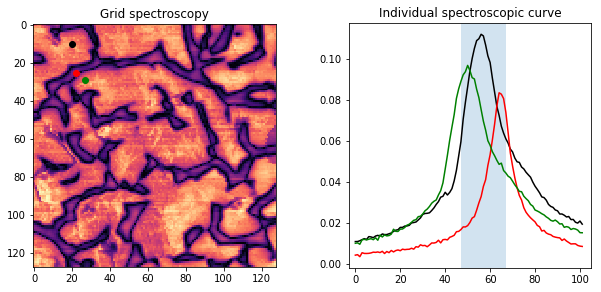

In [5]:
# choose slice
slice_number = 57
spectral_window = 10
# select cooordinates for individual spectroscopic curves
pos = [
       [10, 20], 
       [25, 22], 
       [29, 27],
]
# Plotting
gprutils.plot_raw_data(raw_data, slice_number, pos, spectral_window)

## Prepare data

Take part of data (for testing purposes):

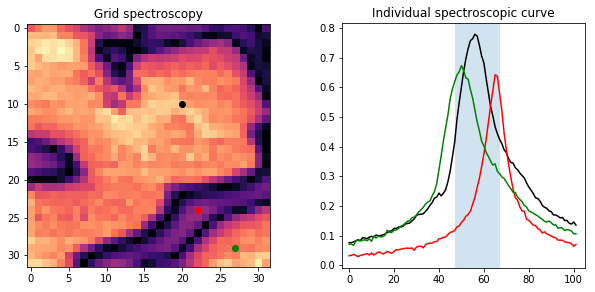

In [6]:
# define crop size
x_start, x_end = 0, 32
y_start, y_end = 0, 32
z_start, z_end = 0, 102
x_res, y_res, z_res = 1, 1, 1
# adjust manually if necessary
pos = [
       [10, 20], 
       [24, 22], 
       [29, 27],
]
# crop and plot
R_true = raw_data[x_start:x_end:x_res, y_start:y_end:y_res, z_start:z_end:z_res]
R_true = (R_true - np.amin(R_true))/np.ptp(R_true)
gprutils.plot_raw_data(R_true, slice_number, pos, spectral_window)

Now we corrupt data by removing certain percentage of the observations:

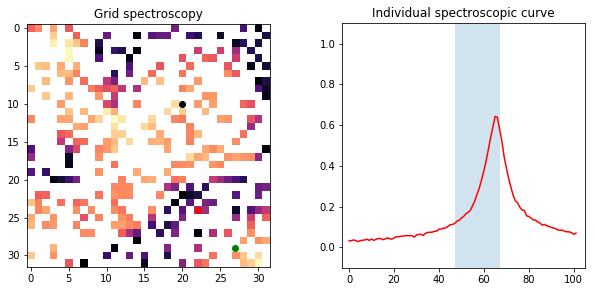

In [7]:
remove_obs = 0.7 # remove 70 % of the data

# Store "true" grid indices before removing parts of the data
e1, e2, e3 = R_true.shape
c1, c2, c3 = np.mgrid[:e1:1., :e2:1., :e3:1.]
X_true = np.array([c1, c2, c3])
# Remove observations and plot the new "corrupted" data
X, R = gprutils.corrupt_data_xy(X_true, R_true, prob=remove_obs)
gprutils.plot_raw_data(R, slice_number, pos, spectral_window, norm=True)

## Gaussian Process Regression Analysis

We now run GP regression on the corrupted data to reconstruct the original signal:

In [8]:
#@title GP regression: model training and prediction (select parameters and click 'Run') { form-width: "50%" }
KERNEL = "Matern52" #@param ["RationalQuadratic", "RBF", "Matern52"]
LENGTH_CONSTR_MIN = 1 #@param {type:"slider", min:1, max:100, step:0.5}
LENGTH_CONSTR_MAX = 20 #@param {type:"slider", min:5, max:100, step:0.5}
LEARNING_RATE = 0.05 #@param {type:"slider", min:0.0005, max:0.1, step:0.0005}
STEPS = 1000 #@param {type:"slider", min:100, max:10000, step:100}
INDUCING_POINTS = 1000 #@param {type:"slider", min:20, max:10000, step:10}
USE_GPU = True #@param ["True", "False"] {type:"raw"}

LENGTH_CONSTR = [
                 [float(LENGTH_CONSTR_MIN) for i in range(3)],
                 [float(LENGTH_CONSTR_MAX) for i in range(3)]
]

reconstructor = gpr.explorer(
    X, R, X_true, KERNEL, LENGTH_CONSTR, INDUCING_POINTS,
    use_gpu=USE_GPU, verbose=True)
model, losses, hyperparams = reconstructor.train_sgpr_model(LEARNING_RATE, STEPS)
mean, sd = reconstructor.sgpr_predict(model, num_batches=100)

# of inducing points for GP regression: 1024
Model training...
iter: 0 ... loss: 43695.8665 ... amp: 1.0 ... length: [1. 1. 1.] ... noise: 1.0 ...
iter: 100 ... loss: -2167.1783 ... amp: 0.0178 ... length: [1.0302 1.0302 1.0302] ... noise: 0.0369508 ...
average time per iteration: 0.1991 s
iter: 200 ... loss: -59965.06 ... amp: 0.0052 ... length: [ 2.6883  4.0004 15.8865] ... noise: 0.0007031 ...
iter: 300 ... loss: -61713.01 ... amp: 0.0053 ... length: [ 2.5859  3.9465 16.0979] ... noise: 0.0005914 ...
iter: 400 ... loss: -62024.0707 ... amp: 0.0053 ... length: [ 2.5748  3.9254 16.1059] ... noise: 0.0005747 ...
iter: 500 ... loss: -62102.0934 ... amp: 0.0053 ... length: [ 2.5706  3.9212 16.1141] ... noise: 0.0005706 ...
iter: 600 ... loss: -62146.757 ... amp: 0.0054 ... length: [ 2.572   3.9393 16.141 ] ... noise: 0.0005685 ...
iter: 700 ... loss: -62174.4506 ... amp: 0.0054 ... length: [ 2.5801  3.9476 16.1761] ... noise: 0.0005679 ...
iter: 800 ... loss: -62208.9243 ... amp: 0.0055 

Plot the evolution of hyperparameters during the training:

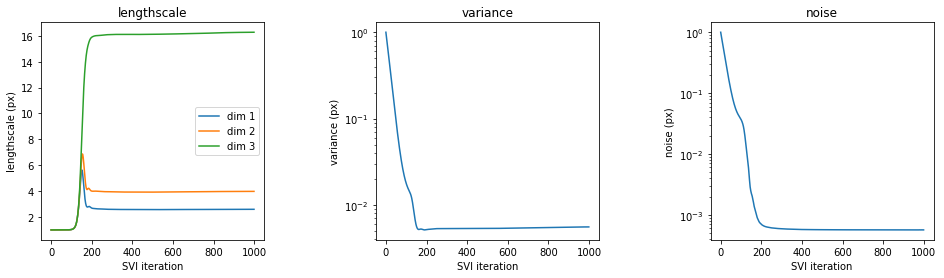

In [9]:
gprutils.plot_kernel_hyperparams(hyperparams)

Plot the evolution of inducing points:

(may take up to ~1 minute)

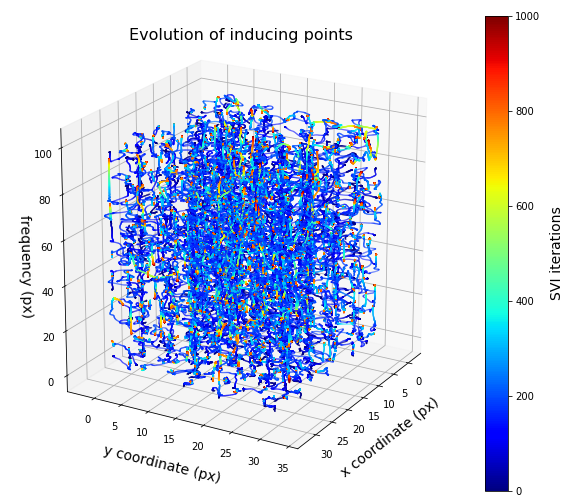

In [10]:
gprutils.plot_inducing_points(hyperparams)

Plot the results:

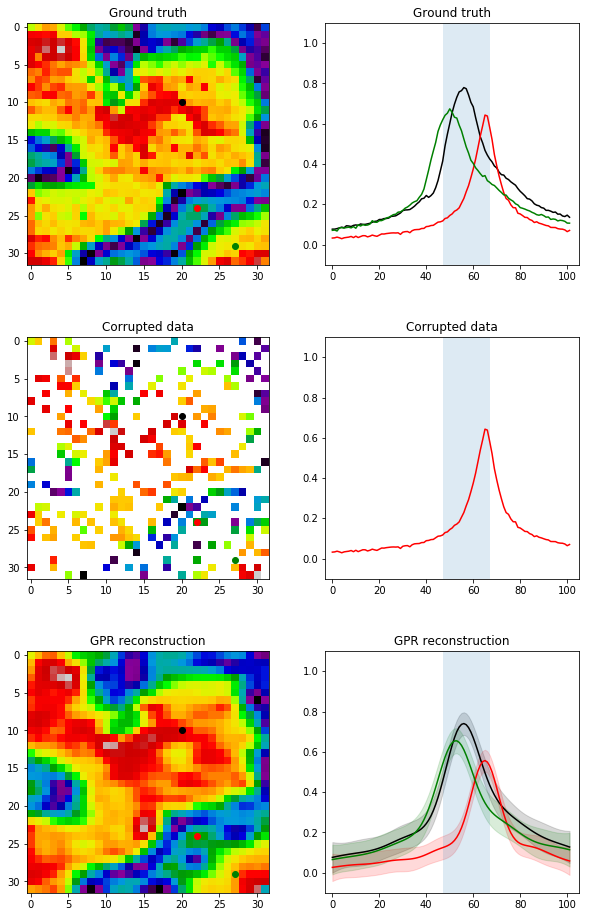

In [11]:
gprutils.plot_reconstructed_data(R, mean, sd, R_true, slice_number, pos, spectral_window)

## Sample exploration with GP regression

We are now going to expore our "sample" in the iterative fashion:
Use GPR to reconstruct data from initial "observations" --> do "measurement" in the point with maximum uncertainty (as estimated from GPR) --> Add the new "measured" points to the initial points --> repeat.

Prepare data:

In [0]:
# define crop size
x_start, x_end = 0, 32
y_start, y_end = 0, 32
z_start, z_end = 0, 102
x_res, y_res, z_res = 1, 1, 1
# get the subset of data
R_true = raw_data[x_start:x_end:x_res, y_start:y_end:y_res, z_start:z_end:z_res]
R_true = (R_true - np.amin(R_true))/np.ptp(R_true)
# remove 99.5 % of the data
remove_obs = 0.995 
e1, e2, e3 = R_true.shape
c1, c2, c3 = np.mgrid[:e1:1., :e2:1., :e3:1.]
X_true = np.array([c1, c2, c3])
X, R = gprutils.corrupt_data_xy(X_true, R_true, prob=remove_obs)

Run the analysis. We are going to increase a learning rate while decreasing a number of SVI steps in each iteration to see how fast we can discover new things in the "sample".

(notice that the size of a measurement square is defined as 2*M+1, so that M=0 corresponds to a doing a single measurement)

In [0]:
#@title GP exploration (select parameters and click 'Run') { form-width: "40%" }
EXPLORATION_STEPS = 65 #@param {type:"slider", min:1, max:100, step:1}
MEASUREMENT_AREA = 0 #@param {type:"slider", min:0, max:5, step:1}
KERNEL = "Matern52" #@param ["RationalQuadratic", "RBF", "Matern52"]
LENGTH_CONSTR_MIN = 1 #@param {type:"slider", min:1, max:100, step:0.5}
LENGTH_CONSTR_MAX = 20 #@param {type:"slider", min:5, max:100, step:0.5}
LEARNING_RATE = 0.1 #@param {type:"slider", min:0.0005, max:0.1, step:0.0005}
STEPS = 1000 #@param {type:"slider", min:100, max:10000, step:100}
#INDUCING_POINTS = 1000 #@param {type:"slider", min:20, max:10000, step:10}
DISTANCE_EDGE = 3 #@param {type:"slider", min:0, max:10, step:1}
USE_GPU = True #@param ["True", "False"] {type:"raw"}
SAVE_DIR = "Output" #@param {type:"string"}


LENGTH_CONSTR = [
                 [float(LENGTH_CONSTR_MIN) for i in range(3)],
                 [float(LENGTH_CONSTR_MAX) for i in range(3)]
]
DIST_EDGE = [DISTANCE_EDGE, DISTANCE_EDGE]
MSIZE = MEASUREMENT_AREA

# Run exploratory analysis
uncert_idx_all, uncert_val_all, mean_all, sd_all, R_all = [], [], [], [], []
if not os.path.exists(SAVE_DIR): os.makedirs(SAVE_DIR)
for i in range(EXPLORATION_STEPS):
    print('Exploration step {}/{}'.format(i, EXPLORATION_STEPS))
    # Make the number of inducing points dependent on the number of datapoints
    indpoints = len(gprutils.prepare_training_data(X, R)[0]) // 10
    # Initialize explorer
    bexplorer = gpr.explorer(
        X, R, X_true, KERNEL, LENGTH_CONSTR, indpoints, use_gpu=USE_GPU)
    # get indices/value of a max uncertainty point
    uncert_idx, uncert_val, mean, sd = bexplorer.step(
        LEARNING_RATE, STEPS, DIST_EDGE)
    # some safeguards (to not stuck at one point)
    uncert_idx, uncert_val = gprutils.checkvalues(
        uncert_idx, uncert_idx_all, uncert_val)
    # store intermediate results 
    uncert_idx_all.append(uncert_idx)
    uncert_val_all.append(uncert_val)
    R_all.append(copy.deepcopy(R.flatten()))
    mean_all.append(copy.deepcopy(mean))
    sd_all.append(copy.deepcopy(sd))
    # make a "measurement" in the point with maximum uncertainty
    print('Doing "measurement"...\n')
    R, X = gprutils.do_measurement(
        R_true, X_true, R, X, uncert_idx, MSIZE)
    # (over)write results on disk
    np.save(os.path.join(
        SAVE_DIR, 'sgpr_bepfm_R_4.npy'), R_all)
    np.save(os.path.join(
        SAVE_DIR, 'sgpr_bepfm_means_4.npy'), mean_all)
    np.save(os.path.join(
        SAVE_DIR, 'sgpr_bepfm_sd_4.npy'), sd_all)
    np.save(os.path.join(
        SAVE_DIR, 'sgpr_bepfm_amax_4.npy'), uncert_idx_all)

Exploration step 0/65
# of inducing points for GP regression: 62
Model training...
average time per iteration: 0.0173 s
training completed in 18.22 s
Final parameter values:
 amp: 0.0249, lengthscale: [ 8.3281 19.8091 18.9077], noise: 0.0002326
Calculating predictive mean and variance...
Maximum uncertainty of 13.529575555838603 at [3, 28]
Doing "measurement"...

Exploration step 1/65
# of inducing points for GP regression: 72
Model training...
average time per iteration: 0.0216 s
training completed in 20.24 s
Final parameter values:
 amp: 0.0204, lengthscale: [ 8.0182 18.6885 18.8708], noise: 0.000218
Calculating predictive mean and variance...
Maximum uncertainty of 12.408254178129162 at [28, 3]
Doing "measurement"...

Exploration step 2/65
# of inducing points for GP regression: 82
Model training...
average time per iteration: 0.016 s
training completed in 18.38 s
Final parameter values:
 amp: 0.0215, lengthscale: [ 8.3768 17.3876 19.147 ], noise: 0.0002168
Calculating predictive me

Plot the results:

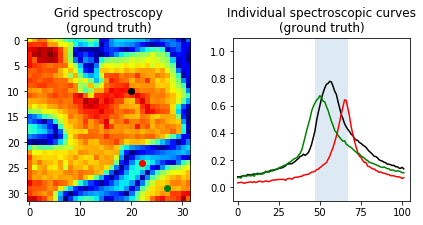

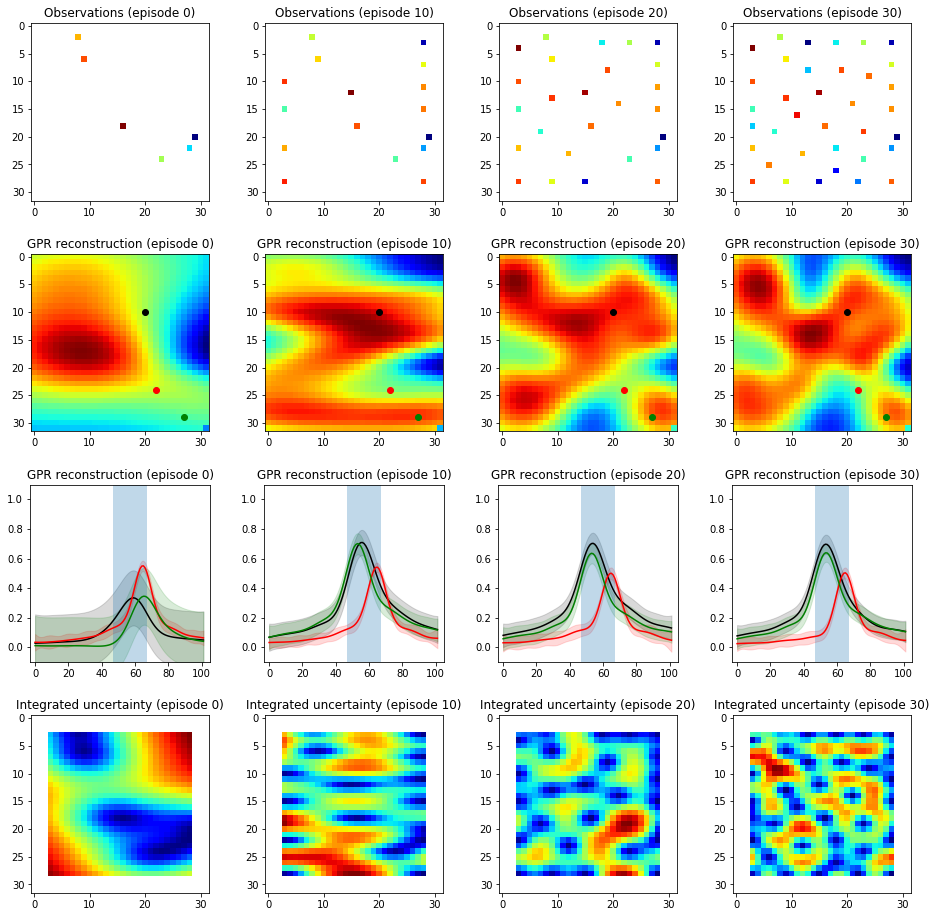

In [0]:
steps = [0, 10, 20, 30] # view results at these exploration steps
pos = [
       [10, 20], 
       [24, 22], 
       [29, 27],
]
slice_number = 57
spec_window = 10
dist_edge = DIST_EDGE

gprutils.plot_exploration_results(
    R_all, mean_all, sd_all, R_true, steps,
    slice_number, pos, dist_edge, spec_window)

Plot the exploration path inthe *xy* space:

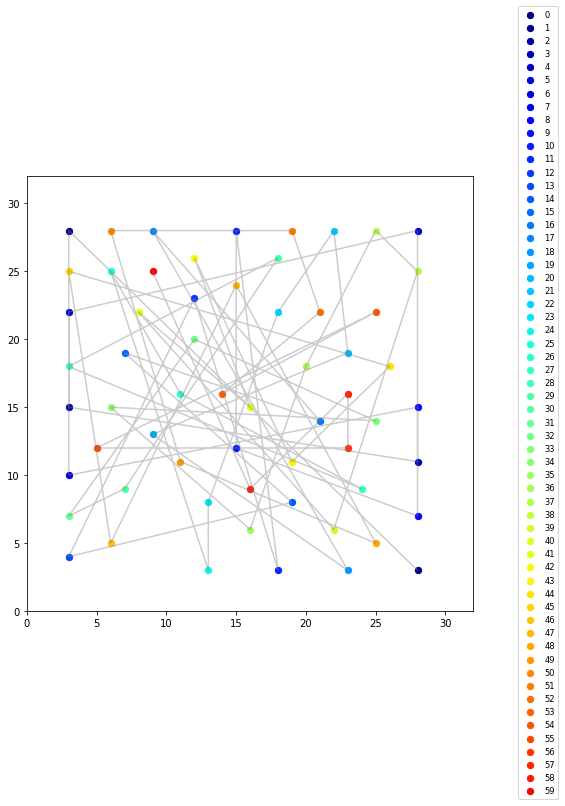

In [0]:
amax_to_plot = uncert_idx_all[:60]
fig, ax = plt.subplots(1, 1, figsize = (8, 8))
labels = range(0, len(uncert_idx_all))
_line_plot = np.empty((0, 2))
for p, l in zip(amax_to_plot, labels):
    _line_plot = np.append(_line_plot, [np.array(p)], axis=0)
    ax.scatter(p[1], p[0], s=40, label=l)
ax.plot(_line_plot[:, 1], _line_plot[:, 0], c='gray', alpha=.4)
ax.set_xlim(0, R_true.shape[0])
ax.set_ylim(0, R_true.shape[1])
colormap = cm.jet
colorst = [colormap(i) for i in np.linspace(0, 0.9,len(ax.collections))]
for t, j in enumerate(ax.collections):
    j.set_color(colorst[t])
ax.legend(fontsize='small', bbox_to_anchor=(1.2, 1.4))

We can also quickly calculate and plot integrated uncertainty and integrated absolute error versus exploration steps:

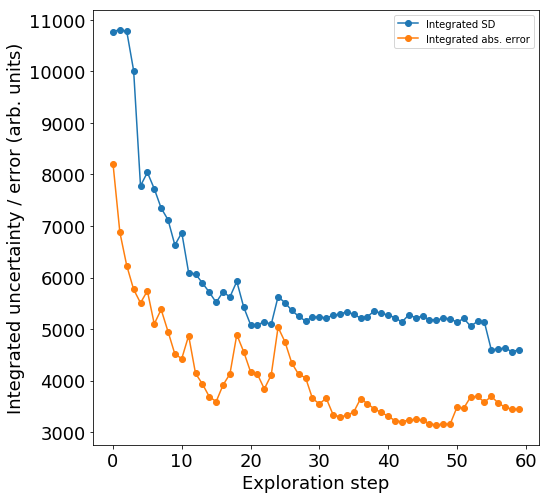

In [0]:
sum_uncert_all, sum_error_all = [], []
for i in range(60):
    sum_error = np.sum(np.abs(R_true.flatten() - mean_all[i]))
    sum_error_all.append(sum_error)
    sum_uncert = np.sum(sd_all[i])
    sum_uncert_all.append(sum_uncert)
plt.figure(figsize=(8, 8))
plt.plot(sum_error_all, '-o', label='Integrated SD')
plt.plot(sum_uncert_all, '-o', label='Integrated abs. error')
plt.xlabel('Exploration step', fontsize=18)
plt.ylabel('Integrated uncertainty / error (arb. units)', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend()
plt.show()